In [2]:
%matplotlib inline
%load_ext rpy2.ipython
import os
import scipy

GIMME_DIR = "/home/isaac/gimmeSAD"
SIMOUT_DIR = os.path.join(GIMME_DIR, "simout/")

os.chdir(GIMME_DIR)
import gimmeSAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import glob
import subprocess

## Gather all the colonization time vectors for all the simulations

In [3]:
files = glob.glob(SIMOUT_DIR + "*5000*/coltimes.txt")
dat = []
for f in files:
    lines = open(f).readlines()[1:]
    new_lines = []
    for line in lines:
        try:
            ## Parse each line and get rid of bracket characters
            l = [float(x.translate(None, "[],")) for x in line.strip().split()]
            ## Convert colonization time, which is recorded as the timestep of 
            ## colonization, to absolute time, basically subtract each coltime
            ## per species from the "current" time
            l = [l[0]] + [l[1] - x for x in l[2:]]
            new_lines.append(l)
        except Exception as inst:
            print(inst)
    dat.extend(new_lines)
print("Processed ntimepoints {}".format(len(dat)))
print(dat[:1])


Processed ntimepoints 5057
[[0.1084, 3641.0, 2101.0, 3519.0, 993.0, 7775.0, 6784.0, 6178.0, 5464.0, 7697.0, 7121.0, 7684.0, 7440.0, 10407.0, 14179.0, 2670.0, 8659.0, 156.0, 14893.0, 3565.0, 6458.0, 4033.0, 1046.0, 2764.0, 1510.0, 8438.0, 12397.0, 753.0, 7718.0, 9348.0, 8349.0, 15066.0, 15041.0, 7952.0, 6274.0, 4926.0, 5091.0, 401.0, 4627.0, 12405.0, 602.0, 490.0, 18385.0, 7969.0, 5863.0, 1376.0, 17600.0, 4594.0, 4828.0, 12388.0, 15406.0, 1007.0, 3535.0, 15374.0, 1248.0, 1063.0, 649.0, 9930.0, 11428.0, 7591.0, 4300.0, 7562.0, 5693.0, 7147.0, 801.0, 2969.0, 7008.0, 477.0, 13215.0, 183.0, 3754.0, 6794.0, 1581.0, 18175.0, 10423.0, 15127.0, 513.0, 5933.0, 336.0, 3602.0, 3540.0, 4526.0, 18048.0, 4301.0, 3158.0, 4020.0, 2003.0, 5023.0, 8472.0, 6557.0, 19906.0, 16012.0, 7201.0, 17719.0, 17891.0, 15828.0, 1203.0, 3178.0, 6596.0, 4583.0, 15481.0, 3080.0, 9205.0, 7814.0, 2099.0, 422.0, 14323.0, 1263.0, 11799.0, 403.0, 17820.0, 1644.0, 551.0, 5548.0, 13071.0, 13244.0, 19999.0, 6062.0, 5111.0, 3930

## Now we have to go through all the data and pick out timepoints that are "close"
## to our timepoints of interest

In [4]:
time_tolerance = 0.01
sampling_lambdas = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

## Dict for storing distributions per timepoint
lambda_dists = {perc:[] for perc in sampling_lambdas}

## Ineffecient but i don't care
for percent in sampling_lambdas:
    coltimes = []
    for line in dat:
        ## If the difference between the lambda for each line
        ## is close enough to the sampling lambda we want then keep the coltimes
        if abs(line[0] - percent) < time_tolerance:
            coltimes.extend(line[2:])
    lambda_dists[percent] = coltimes
print("Got n coltimes per lambda:")
for k,v in lambda_dists.items():
    print("\t{}\t- {}".format(k, len(v)))

Got n coltimes per lambda:
	0.25	- 35026
	0.5	- 14929
	0.05	- 76411
	0.1	- 58519
	1	- 429073
	0.75	- 22976


In [ ]:
from scipy.stats import expon
f, axarr = plt.subplots(2, 3, figsize=(8,4), dpi=300)
axarr = [a for b in axarr for a in b]

for k, ax in zip(sampling_lambdas, axarr):
    ax.set_title(u"Λ = {}".format(k))
    coltimes = lambda_dists[k]
    ax.hist(coltimes)
    ax.set_ylabel('N Species', color='b')
    ax.set_xlabel('Colonization Time', color='b')
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    #ax.get_xaxis().set_ticks(np.arange(min(coltimes), max(coltimes)+1, 1.0))
    data = sorted(coltimes)
    loc, sc = expon.fit(data, floc=0)
    print("{} {}".format(k, sc))
    rv = expon(scale=sc)
    x = np.linspace(0, max(data), 100)
    
    ax1 = ax.twinx()
    ax1.plot(x, rv.pdf(x))
    ax1.get_yaxis().set_ticks([])
plt.tight_layout()

0.05 162241.682729
0.1 118896.5212
0.25 117487.844328
0.5 112716.856197
0.75 142883.987666


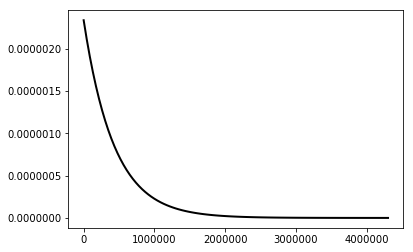

In [85]:
plt.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

In [1]:
np.arange(min(coltimes), max(coltimes)+1, 1.0)

NameError: name 'np' is not defined